In [1]:
from tensorflow import keras
import tensorflow_datasets.public_api as tfds
import tensorflow as tf

Создаём датасет с цветочками

In [2]:
# Константы
img_side = 192

# Разбиваем датасет на тренировочную группу и группу валидации
def init_data_with_batch_size(batch_size):
    global train_data
    train_data = tf.keras.utils.image_dataset_from_directory(
        "flowers",
        image_size=(img_side, img_side),
        shuffle=True,
        batch_size=batch_size,
    )

    # Убираем лейблы (т.к. у нас задача не распознавать изображения)
    train_data = train_data.map(lambda x, y: (x/255.0, x/255.0))

    return train_data

Модель

In [8]:
from keras.layers import (Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D,
                          Dropout, Flatten, Reshape, Lambda, MaxPool2D, Concatenate, add)
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras import backend as K

# Константы
filters = 64
hidden_units = 256
core_size = (3, 3)

# Энкодер
input_img = Input(shape=(img_side, img_side, 3))
x_temp = Conv2D(filters, core_size, activation=act_func, padding="same")(input_img)

for _ in range(5):
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x_temp)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)

    x_temp = add([x_temp, x])
    x_temp = MaxPool2D((2, 2))(x_temp)

# x = Flatten()(x_temp)
# x = Dense(hidden_units, activation=act_func)(x)
# x_temp = Reshape((int(hidden_units**.5), int(hidden_units**.5), 1))(x)
# x_temp = BatchNormalization()(x_temp)

# Декодер
for upsampling in [(4, 4), (2, 2), (4, 4), (2, 2)]:
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x_temp)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)
    x = Conv2D(filters, core_size, activation="relu", padding="same")(x)

    x_temp = add([x_temp, x])
    x_temp = UpSampling2D(upsampling)(x_temp)

x = Conv2D(3, core_size, activation="sigmoid", padding="same")(x)
output_img = Reshape((img_side, img_side, 3))(x)

# Модель
vae = Model(input_img, output_img, name="vae")

vae.compile(
    optimizer=keras.optimizers.Adamax(5e-3),
    loss=keras.losses.binary_crossentropy,
    loss_weights=[1000],
)

vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_112 (Conv2D)            (None, 192, 192, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_113 (Conv2D)            (None, 192, 192, 64  36928       ['conv2d_112[0][0]']             
                                )                                                               

In [10]:
train_data = init_data_with_batch_size(1)
vae.fit(
    train_data,
    epochs=55,
)

Found 1671 files belonging to 5 classes.
Epoch 1/55
1671/1671 [==============================] - 122s 72ms/step - loss: 530.4062
Epoch 2/55
1671/1671 [==============================] - 122s 73ms/step - loss: 508.9042
Epoch 3/55
1671/1671 [==============================] - 123s 73ms/step - loss: 502.4224
Epoch 4/55
1671/1671 [==============================] - 119s 71ms/step - loss: 495.7328
Epoch 5/55
1671/1671 [==============================] - 170s 102ms/step - loss: 492.8493
Epoch 6/55
1148/1671 [===================>..........] - ETA: 37s - loss: 491.3778

KeyboardInterrupt: 

Found 1671 files belonging to 5 classes.
1/1 [==============================] - 0s 17ms/step


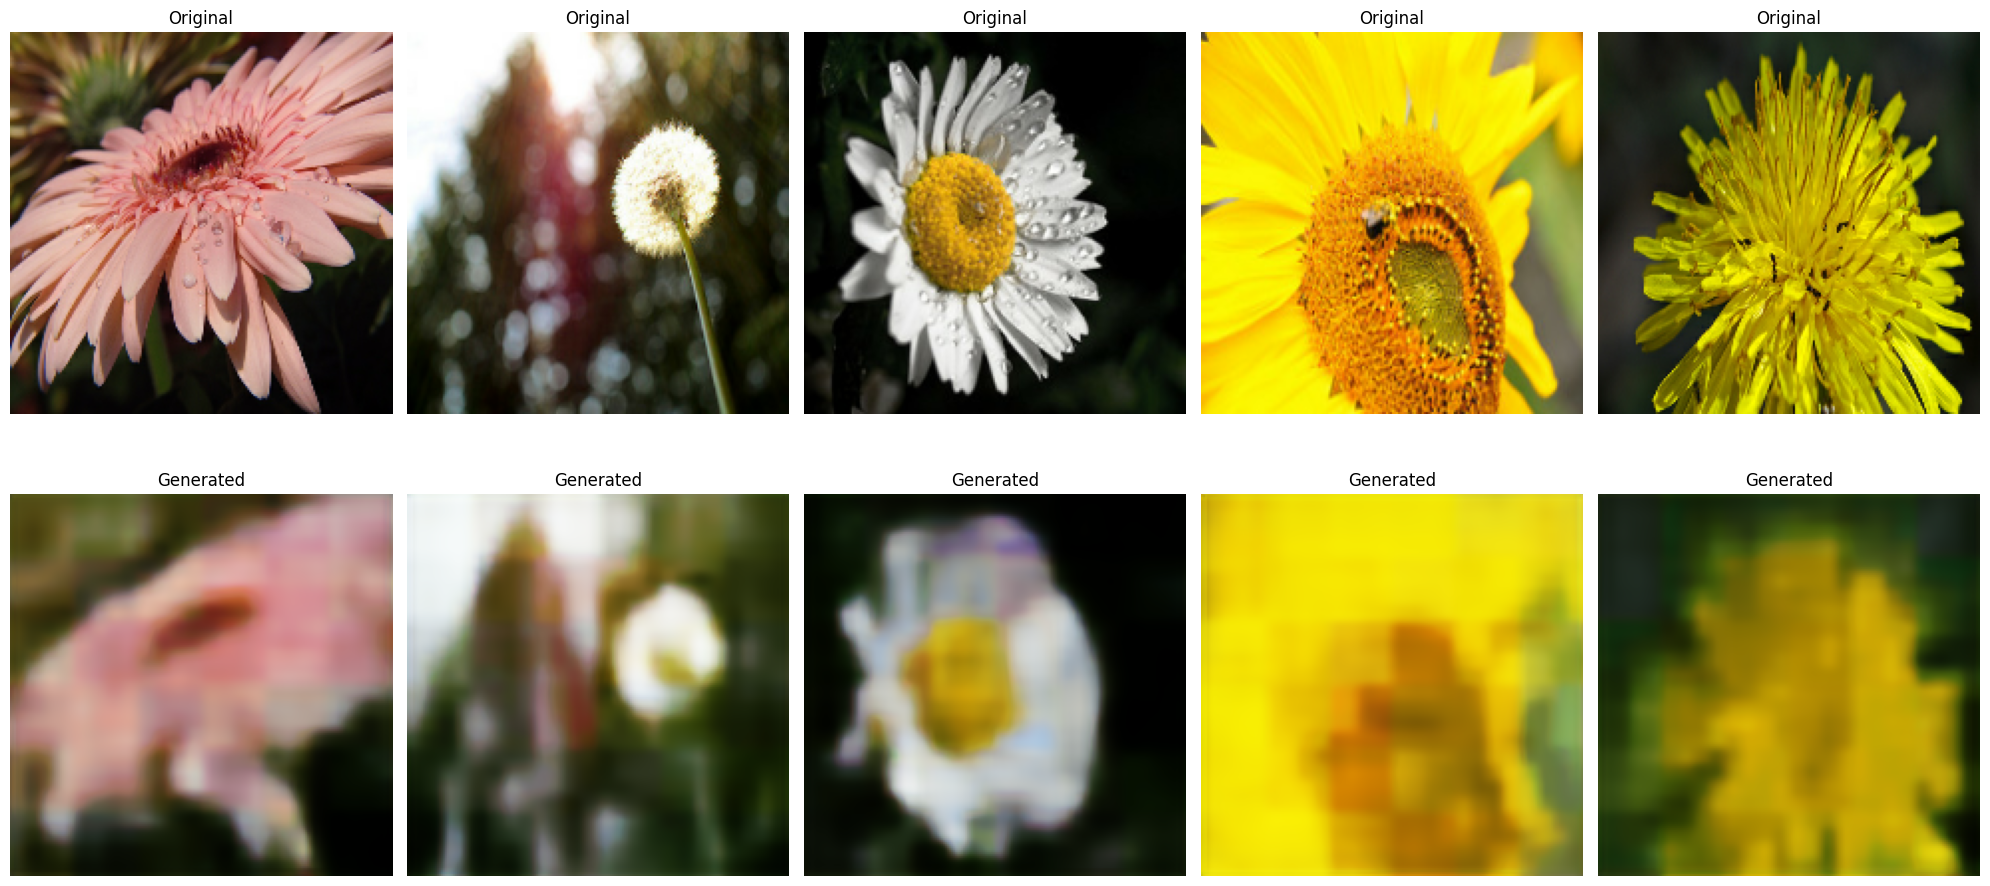

In [13]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np

data = np.array([i[0][0] for i in init_data_with_batch_size(1)][:10])
generated_images = vae.predict(data)

num_images = 5

plt.figure(figsize=(20, 10))

def print_images():
    for _ in range(num_images):
        random_num = randint(0, len(data))
        # Исходное изображение
        plt.subplot(2, num_images, _ + 1)
        plt.imshow(data[random_num])
        plt.title("Original")
        plt.axis("off")

        # Сгенерированное изображение
        plt.subplot(2, num_images, _ + num_images + 1)
        plt.imshow(generated_images[random_num])
        plt.title("Generated")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print_images()